In [1]:
import numpy as np
from scipy import stats
from scipy.stats import binom, norm
from scipy.stats import t as studentt
import matplotlib
import matplotlib.pyplot as plt
import random
from collections import namedtuple
from enum import Enum
from typing import List
import math
import json

In [2]:
def transition_momentum(p, param, hd_fn, epsilon):
    return p - 0.5 * epsilon * hd_fn(param)

def transition_param(param, p_half, epsilon):
    paramd = param + epsilon * p_half
    return paramd

def leap_frog(p, param, hd_fn, epsilon, L):
    phs = [p]
    prms = [param]
    ps = [p]
    for t in range(L):
        p_half = transition_momentum(p, param, hd_fn, epsilon)
        param = transition_param(param, p_half, epsilon)
        p = transition_momentum(p_half, param, hd_fn, epsilon)
        phs.append(p_half)
        prms.append(param)
        ps.append(p)
    return p, param, phs, prms, ps

def hamiltonian(param, p, h_fn):
    ht = h_fn(param)
    pt = 0.5 * np.sum(p * p)
    return ht + pt, ht, pt

def btl_to_ps(bs):
    denom = bs[:, np.newaxis] + bs[np.newaxis, :]
    return bs[:, np.newaxis] / denom

def h_binom(bs, ks, ns):
    mask = (ns != 0).astype(np.float32)
    ps = btl_to_ps(bs)
    h = ks * np.log(ps + 1e-12)
    return -np.sum(h * mask)

def hd_btl(bs, ks, ns):
    mask = (ns != 0).astype(np.float32)
    ps = btl_to_ps(bs)
    hd = -(ks - ns * ps) / bs[:, np.newaxis]
    return np.sum(hd * mask, axis=1)

def h_binom_reg2(bs, ks, ns, lam):
    h1 = h_binom(bs, ks, ns)
    h2 = lam * np.square(1 - bs.sum())
    return h1 + h2

def hd_btl_reg2(bs, ks, ns, lam):
    dp = hd_btl(bs, ks, ns)
    l = -2 * lam * (1-bs.sum())
    return dp + l

def hmc_nd(param, u, h_fn, hd_fn, epsilon, L):
    p = norm.rvs(size=len(param))
    hml, ht, pt = hamiltonian(param, p, h_fn)
    pd, paramd, phs, prms, ps = leap_frog(p, param, hd_fn, epsilon, L)
    hmld, htd, ptd = hamiltonian(paramd, pd, h_fn)
    hml_diff = hml - hmld
    r = np.exp(hml_diff)
    r_test = stats.uniform.rvs(size=1)[0]
    if r_test <= r:
        return paramd, (hml, ht, pt), (hmld, htd, ptd), hml_diff, u + 1
    else:
        return param, (hml, ht, pt), (hmld, htd, ptd), hml_diff, u

def hmc_all(k_table, n_table, bs, epsilon, L, lam, n_sample):
    I, J = k_table.shape
    b_results = [[] for _ in range(I)]
    p_results = [[[] for _ in range(J)] for _ in range(I)]
    hml_results = [[[] for _ in range(J)] for _ in range(I)]
    ht_results = [[[] for _ in range(J)] for _ in range(I)]
    pt_results = [[[] for _ in range(J)] for _ in range(I)]
    hmld_results = [[[] for _ in range(J)] for _ in range(I)]
    htd_results = [[[] for _ in range(J)] for _ in range(I)]
    ptd_results = [[[] for _ in range(J)] for _ in range(I)]
    hml_diff_results = [[[] for _ in range(J)] for _ in range(I)]
    u = 0
    def h_fn(bs):
        return h_binom_reg2(bs, k_table, n_table, lam)
    def hd_fn(bs):
        return hd_btl_reg2(bs, k_table, n_table, lam)
    for s in range(n_sample):
        bs, (hml, ht, pt), (hmld, htd, ptd), hml_diff, u = hmc_nd(bs, u, h_fn, hd_fn, epsilon, L)
        for i in range(I):
            b_results[i].append(bs[i])
            for j in range(J):
                p_results[i][j].append(bs[i] / (bs[i] + bs[j]))
                hml_results[i][j].append(hml)
                ht_results[i][j].append(ht)
                pt_results[i][j].append(pt)
                hmld_results[i][j].append(hmld)
                htd_results[i][j].append(htd)
                ptd_results[i][j].append(ptd)
                hml_diff_results[i][j].append(hml_diff)
    return b_results, p_results, (hml_results, ht_results, pt_results),\
    (hmld_results, htd_results, ptd_results), hml_diff_results, u

def leap_frog_simulation_binom_reg2(p_init, param_bs_init, k_table, n_table, epsilon, L, lam):
    param_ps_init = btl_to_ps(param_bs_init)
    def h_fn(bs):
        return h_binom_reg2(bs, k_table, n_table, lam)
    def hd_fn(bs):
        return hd_btl_reg2(bs, k_table, n_table, lam)
    
    hml_init, ht_init, pt_init = hamiltonian(param_bs_init, p_init, h_fn)
    p, param, phs, prms, ps = leap_frog(p_init, param_bs_init, hd_fn, epsilon, L)
    hml_fin, ht_fin, pt_fin = hamiltonian(param, p, h_fn)
    return (p, param, phs, prms, ps), (hml_init, ht_init, pt_init), (hml_fin, ht_fin, pt_fin)

def confint(n, delta):
    a = np.log(4 * n * n) - np.log(delta)
    b = a / n * 0.5
    c = np.sqrt(b)
    return c

def max_n(epsilon, delta):
    epsilon2 = epsilon * epsilon
    return int(np.ceil(0.5 / epsilon2 * np.log(2.0 / delta)))

def find_n(p, epsilon, delta, mn):
    n = 1
    while confint(n, delta) - np.abs(p - 0.5) - epsilon > 0:
        n += 1
        if n >= mn:
            return n
    return n

In [3]:
with open("test_score-X0VJzx6LqO8b.json", mode='r') as f:
    score_results = json.load(f)
with open("merge_ranks.json", mode='r') as f:
    results = json.load(f)

systems_abb = {}
for s in score_results['result']['questions'][0]['systems']:
    systems_abb[s['name']] = s['abbreviation']
def get_key(val):
    for key, value in systems_abb.items():
        if val == value:
            return key
    return "key doesn't exist"
systems_ranked = [get_key(s) for s in results['result']['experimental_manifests'][0]['merge_rank']['s_merged']]
commands = results['result']['experimental_manifests'][0]['compare_commands']
systems = [systems_abb[s] for s in systems_ranked]
system_to_index = {s: i for i, s in enumerate(systems)}

In [4]:
result_map_tmp = np.zeros((len(systems), len(systems)), dtype=np.int32)
for r in commands:
    result_map_tmp[system_to_index[r['system_i']], system_to_index[r['system_j']]] = r['n_results']

In [5]:
def gen_pairs():
    for i in reversed(range(len(systems))):
        for j in reversed(range(len(systems))):
            if (result_map_tmp[i, j] == 0):
                pass
            else:
                yield (systems[i],systems[j])
system_pairs = list(gen_pairs())
print(len(systems))
print(len(system_pairs))

15
32


In [6]:
n_table = np.zeros((len(systems),len(systems)), dtype=np.int32)
k_table = np.zeros((len(systems),len(systems)), dtype=np.int32)
for pair in system_pairs:
    pair_data = [s for s in score_results["result"]["scores"] if s["samples"]["sample_i"]["system"]["abbreviation"] == pair[0] and s["samples"]["sample_j"]["system"]["abbreviation"] == pair[1]]
    n_results = len(pair_data)
    total_value = sum([v["score_value"] for v in pair_data])
    system_i = pair[0]
    system_j = pair[1]
    n_table[system_to_index[system_i], system_to_index[system_j]] = n_results
    n_table[system_to_index[system_j], system_to_index[system_i]] = n_results
    k_table[system_to_index[system_i], system_to_index[system_j]] = total_value
    k_table[system_to_index[system_j], system_to_index[system_i]] = n_results - total_value

epsilon = 0.1013
delta = 0.05
mn = max_n(epsilon, delta)
print(mn)

180


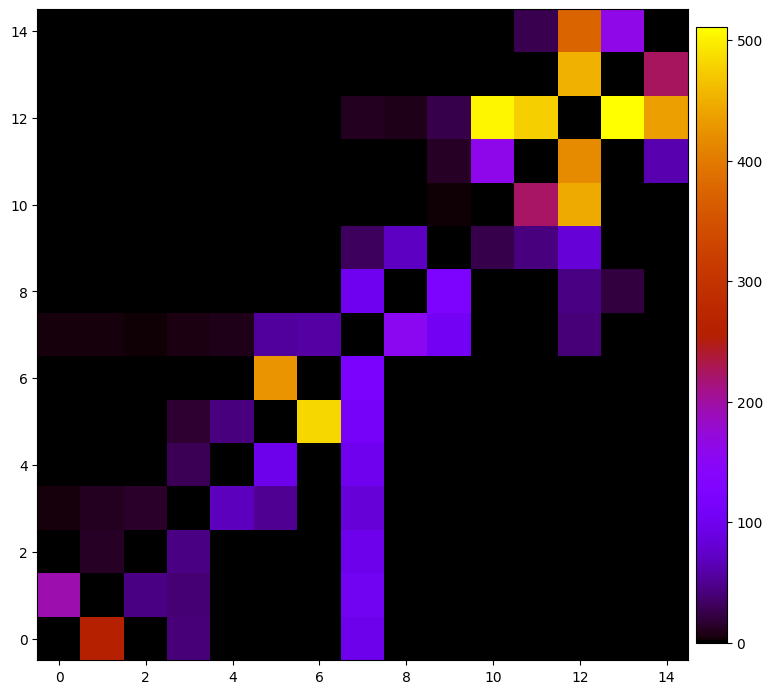

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(k_table, origin="lower", cmap='gnuplot', vmin=0)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

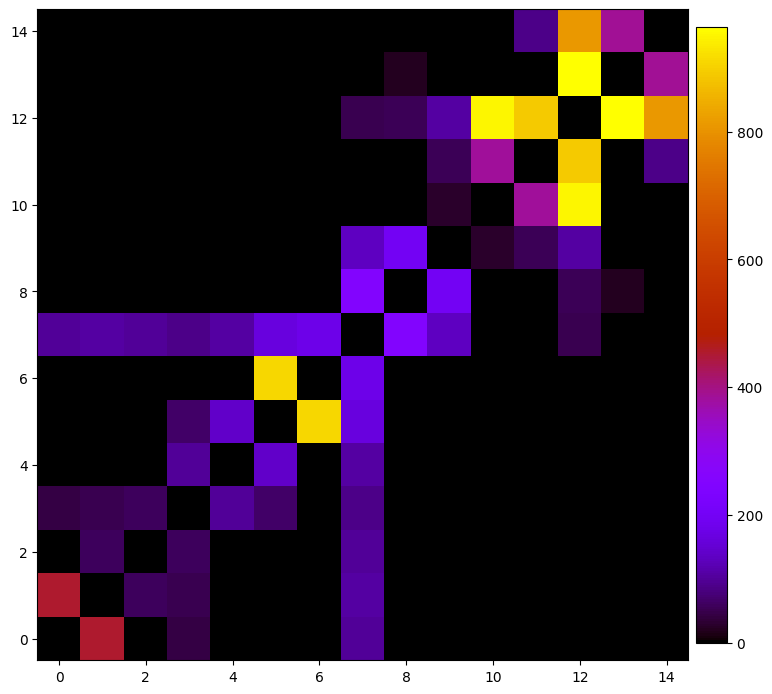

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(n_table, origin="lower", cmap='gnuplot', vmin=0)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

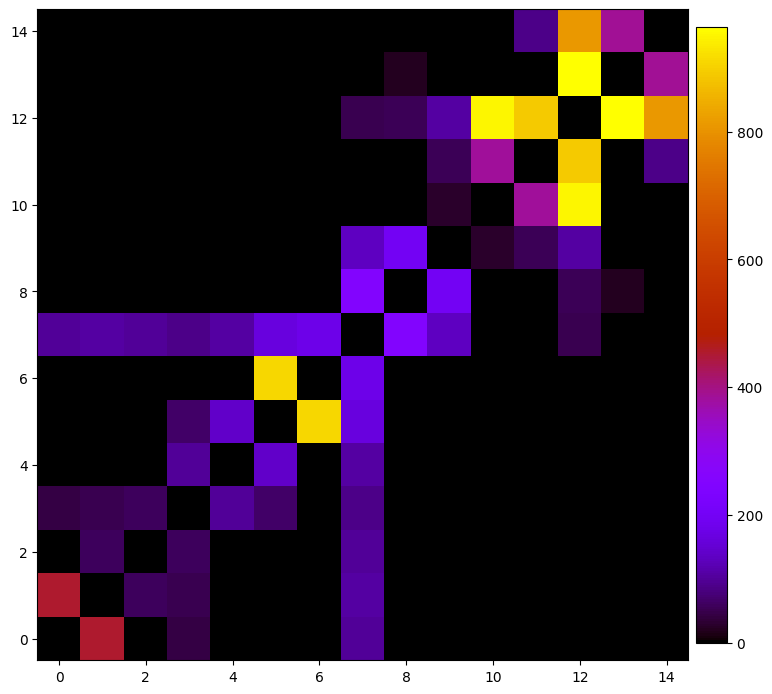

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(n_table, origin="lower", cmap='gnuplot', vmin=0)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

In [7]:
p_init = norm.rvs(size=len(systems))
bs_init = np.array([1/len(systems) for _ in range(len(systems))])
n_sample = 30000
L = 100
eps = 0.00001
lam = 500

print(hamiltonian(bs_init, p_init, lambda bs: h_binom_reg2(bs, k_table, n_table, lam)))

(5621.683455974974, 5614.492162519357, 7.191293455616974)


In [8]:
p_init = norm.rvs(size=len(systems))
(p, param, phs, prms, ps), (hml_init, ht_init, pt_init), (hml_fin, ht_fin, pt_fin) = \
leap_frog_simulation_binom_reg2(p_init, bs_init, k_table, n_table, eps, L=1500, lam=500)
print(hamiltonian(param, p, lambda bs: h_binom_reg2(bs, k_table, n_table, lam)))

(5622.471451062516, 5449.4498021710015, 173.02164889151487)


In [9]:
b_results, p_results, (hml_results, ht_results, pt_results),\
(hmld_results, htd_results, ptd_results), hml_diff_results,\
n_updates = hmc_all(k_table, n_table, bs_init, eps, L, lam, n_sample)

In [10]:
print(n_updates)

29743


In [11]:
with open(f"mcmc_hmc-{n_sample}.json", mode='w') as f:
    data = {
        "btl": b_results,
        # "p": p_results,
        # "hml": hml_results,
        # "ht": ht_results,
        # "pt": pt_results,
        # "hmld": hmld_results,
        # "htd": htd_results,
        # "ptd": ptd_results,
        # "hml_diff": hml_diff_results,
        "n_updates": n_updates,
        "eps": eps,
        "L": L,
        "lam": lam,
        "n_sample": n_sample,
        "systems": systems,
        "lang": "All"
    }
    json.dump(data, f, ensure_ascii=False)

In [12]:
with open("mcmc_hmc-30000.json", mode='r') as f:
    mcmc_hmc = json.load(f)

In [13]:
systems = [s for s in mcmc_hmc["systems"]]
system_to_index = {s: i for i, s in enumerate(reversed(systems))}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


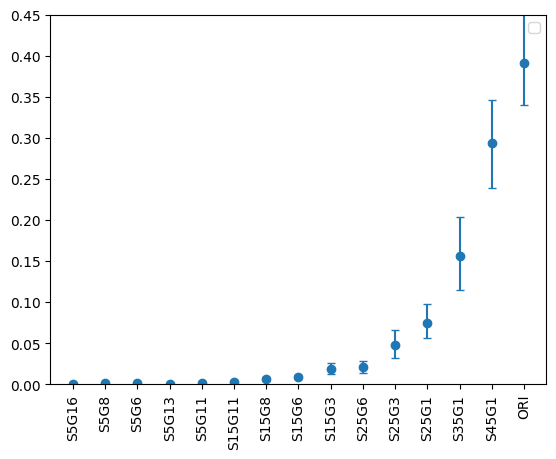

In [14]:
system_index = [system_to_index[s] for s in mcmc_hmc["systems"]]
means = []
stds = []
perc5s = []
perc95s = []
N = 10000
for i, bs in enumerate(mcmc_hmc["btl"]):
    mean = np.mean(bs[N:])
    std = np.std(bs[N:],ddof=1)
    perc5 = np.percentile(bs[N:], 2.5)
    perc95 = np.percentile(bs[N:], 97.5)
    means.append(mean)
    stds.append(std)
    perc5s.append(perc5)
    perc95s.append(perc95)
means = np.array(means)
stds = np.array(stds)
perc5s = np.array(perc5s)
perc95s = np.array(perc95s)
plt.errorbar(system_index,
                means, yerr=[means-perc5s, perc95s-means], fmt='o', capsize=3)
plt.ylim(0, 0.45)
plt.xticks(np.arange(len(means)), list(reversed(systems)), rotation=90)
plt.legend()
plt.savefig('btl_ranking.pdf', bbox_inches="tight")
plt.savefig('btl_ranking.png', bbox_inches="tight", dpi=500)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


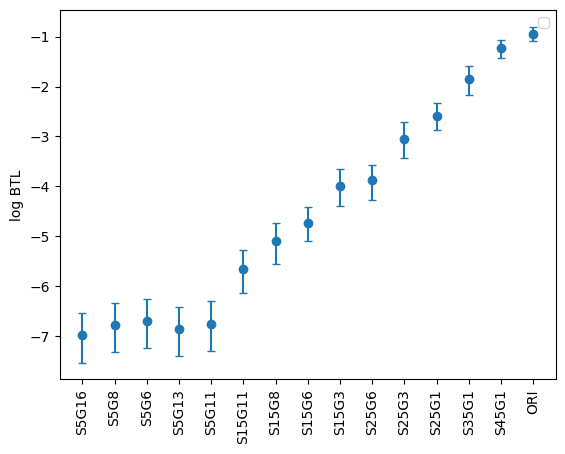

In [15]:
system_index = [system_to_index[s] for s in mcmc_hmc["systems"]]
means = []
stds = []
perc5s = []
perc95s = []
N = 10000
for i, bs in enumerate(mcmc_hmc["btl"]):
    mean = np.mean(bs[N:])
    std = np.std(bs[N:],ddof=1)
    perc5 = np.percentile(bs[N:], 2.5)
    perc95 = np.percentile(bs[N:], 97.5)
    means.append(mean)
    stds.append(std)
    perc5s.append(perc5)
    perc95s.append(perc95)
means = np.array(means)
stds = np.array(stds)
perc5s = np.array(perc5s)
perc95s = np.array(perc95s)
plt.errorbar(system_index,
                np.log(means), yerr=[np.log(means)-np.log(perc5s), np.log(perc95s)-np.log(means)], fmt='o', capsize=3)
plt.xticks(np.arange(len(means)), list(reversed(systems)), rotation=90)
plt.ylabel("log BTL")
plt.legend()
plt.savefig('log_btl_ranking.pdf', bbox_inches="tight")
plt.savefig('log_btl_ranking.png', bbox_inches="tight", dpi=500)

In [16]:
btl_all = {}
systems_all = [s for s in mcmc_hmc["systems"]]
N = 10000
for s, bs in zip(systems_all, mcmc_hmc["btl"]):
    mean = np.mean(bs[N:])
    perc5 = np.percentile(bs[N:], 2.5)
    perc95 = np.percentile(bs[N:], 97.5)
    btl_all[s] = mean
btl_all = sorted(btl_all.items(), key=lambda kv: -kv[1])
btl_all = {k: v for k, v in btl_all}
btl_all

{'ORI': 0.3914826581138082,
 'S45G1': 0.2935240461342248,
 'S35G1': 0.15694030667524048,
 'S25G1': 0.07499541725264075,
 'S25G3': 0.047655188031228334,
 'S25G6': 0.020642537080159264,
 'S15G3': 0.018418131548784532,
 'S15G6': 0.00885183711955824,
 'S15G8': 0.006088741254094116,
 'S15G11': 0.003458482946915697,
 'S5G6': 0.0012229765628535897,
 'S5G11': 0.001166946506047147,
 'S5G8': 0.0011313327835147035,
 'S5G13': 0.001048714193515366,
 'S5G16': 0.000925577558829657}

In [17]:
btl_all_index = {k: i for i, (k,v) in enumerate(reversed(btl_all.items()))}

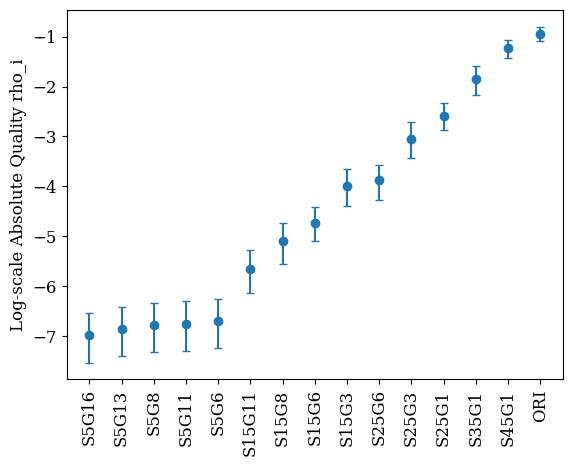

In [21]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Serif",
    'font.size': 16
})
system_index = [btl_all_index[s] for s in mcmc_hmc["systems"]]
means = []
stds = []
perc5s = []
perc95s = []
N = 10000
for i, bs in enumerate(mcmc_hmc["btl"]):
    mean = np.mean(bs[N:])
    std = np.std(bs[N:],ddof=1)
    perc5 = np.percentile(bs[N:], 2.5)
    perc95 = np.percentile(bs[N:], 97.5)
    means.append(mean)
    stds.append(std)
    perc5s.append(perc5)
    perc95s.append(perc95)
means = np.array(means)
stds = np.array(stds)
perc5s = np.array(perc5s)
perc95s = np.array(perc95s)
plt.errorbar(system_index,
                np.log(means), yerr=[np.log(means)-np.log(perc5s), np.log(perc95s)-np.log(means)], fmt='o', capsize=3)
plt.xticks(np.arange(len(means)), list(reversed(btl_all.keys())), rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel("Log-scale Absolute Quality rho_i", fontsize=12)
plt.savefig('log_btl_ranking_btlall_order_jp.pdf', bbox_inches="tight")
plt.savefig('log_btl_ranking_btlall_order_jp.png', bbox_inches="tight", dpi=500)

In [ ]:
print(system_index)
np.log(means)

array([-1.00513928, -1.2554259 , -1.83136738, -2.52913795, -2.96835936,
       -3.80302023, -3.91628867, -4.65515763, -5.02819748, -5.59475136,
       -6.68077202, -6.78677119, -6.63343194, -6.71112808, -6.91184352])